In [4]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2,l1

import warnings


In [5]:
train_data_frame=pd.read_csv("dataset/clean_data/train_clean.csv").drop('Unnamed: 0',axis=1)

In [6]:
test_data_frame=pd.read_csv("dataset/clean_data/test_clean.csv")

In [7]:
class RNN:
    def __init__(self, train_data, test_data, max_vocab_size=5000, max_sequence_len=100, batch_size=32):
        self.train_data = train_data
        self.test_data = test_data
        self.max_vocab_size = max_vocab_size
        self.max_sequence_len = max_sequence_len
        self.batch_size = batch_size

        # Initialize TextVectorization layer
        self.vectorizer = TextVectorization(
            max_tokens=self.max_vocab_size,
            output_sequence_length=self.max_sequence_len,
            standardize='lower_and_strip_punctuation'
        )

    def preprocess_data(self, text_data, is_training=False):
        if is_training:
            self.vectorizer.adapt(text_data)
        sequences = self.vectorizer(text_data)
        return np.array(sequences)

    def build_model(self, model_size='s'):
        if model_size == 's':
            return tf.keras.Sequential([
                tf.keras.layers.Embedding(self.max_vocab_size, 64, input_length=self.max_sequence_len),
                tf.keras.layers.GRU(32, return_sequences=False),
                tf.keras.layers.Dense(16, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        elif model_size == 'm':
            return tf.keras.Sequential([
                tf.keras.layers.Embedding(self.max_vocab_size, 128, input_length=self.max_sequence_len),
                tf.keras.layers.GRU(64, return_sequences=False, dropout=0.3),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dropout(0.4),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        elif model_size == 'l':
            return tf.keras.Sequential([
                tf.keras.layers.Embedding(self.max_vocab_size, 256, input_length=self.max_sequence_len),
                tf.keras.layers.GRU(128, return_sequences=False, dropout=0.3),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        else:
            raise ValueError("Invalid model size. Choose from 's', 'm', or 'l'.")

    def train_model(self, model_size='s', epochs=5, learning_rate=0.001):
        # Preprocess data
        x_train = self.preprocess_data(self.train_data['review_content'], is_training=True)
        y_train = np.array(self.train_data['sentiment'].map({'pos': 1, 'neg': 0}))

        val_sample_size = int(0.2 * len(x_train))
        x_train, x_val = x_train[:-val_sample_size], x_train[-val_sample_size:]
        y_train, y_val = y_train[:-val_sample_size], y_train[-val_sample_size:]

        model = self.build_model(model_size)

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

        # Train model
        history = model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_data=(x_val, y_val),
            callbacks=[early_stop, lr_scheduler]
        )

        self.model = model
        self.history = history

    def evaluate_model(self):
        x_test = self.preprocess_data(self.test_data['review_content'])
        y_test = np.array(self.test_data['sentiment'].map({'pos': 1, 'neg': 0}))

        preds = self.model.predict(x_test, batch_size=self.batch_size)
        binary_preds = (preds > 0.5).astype(int).flatten()

        accuracy = accuracy_score(y_test, binary_preds)
        print(f"Model Accuracy: {accuracy}")

        conf_matrix = confusion_matrix(y_test, binary_preds)
        print("Confusion Matrix:\n", conf_matrix)

        class_report = classification_report(y_test, binary_preds)
        print("Classification Report:\n", class_report)


In [17]:
def train_RNN(num_words, max_length, learning_rate, batch_size, model_size, epochs, use_raw_text):
    model_trainer = RNN(
        train_data=train_data_frame,
        test_data=test_data_frame,
        max_vocab_size=num_words,
        max_sequence_len=max_length,
        batch_size=batch_size
    )
    
    # Train the model
    model_trainer.train_model(
        model_size=model_size,
        epochs=epochs,
        learning_rate=learning_rate
    )
    
    # Print model summary
    model_trainer.model.summary()
    
    # Evaluate the model
    model_trainer.evaluate_model()

    return model_trainer


In [22]:
def plot_accuracy(model_trainer):
    # Extract metrics from history
    train_accuracy = model_trainer.history.history['accuracy']
    val_accuracy = model_trainer.history.history['val_accuracy']
    epochs = range(1, len(train_accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(model_trainer):
    # Extract metrics from history
    train_loss = model_trainer.history.history['loss']
    val_loss = model_trainer.history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
num_words = 500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)


Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.6209 - loss: 0.6698 - val_accuracy: 0.0000e+00 - val_loss: 0.9935 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.6256 - loss: 0.6556 - val_accuracy: 0.4556 - val_loss: 1.1670 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.6131 - loss: 0.6525 - val_accuracy: 0.6446 - val_loss: 0.6994 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.6437 - loss: 0.6031 - val_accuracy: 0.7898 - val_loss: 0.6321 - learning_rate: 0.0030
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.7749 - loss: 0.4810 - val_accuracy: 0.6210 - val_loss: 0.7516 - learning_rate: 0.0030
Epoch 6/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8065 - loss: 0.4359
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.8066 - loss: 0.4355 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 64)             │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,861 (491.65 KB)

 Trainable params: 41,953 (163.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,908 (327.77 KB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
Model Accuracy: 0.80232
Confusion Matrix:
 [[ 9382  3118]
 [ 1824 10676]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79     12500
           1       0.77      0.85      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



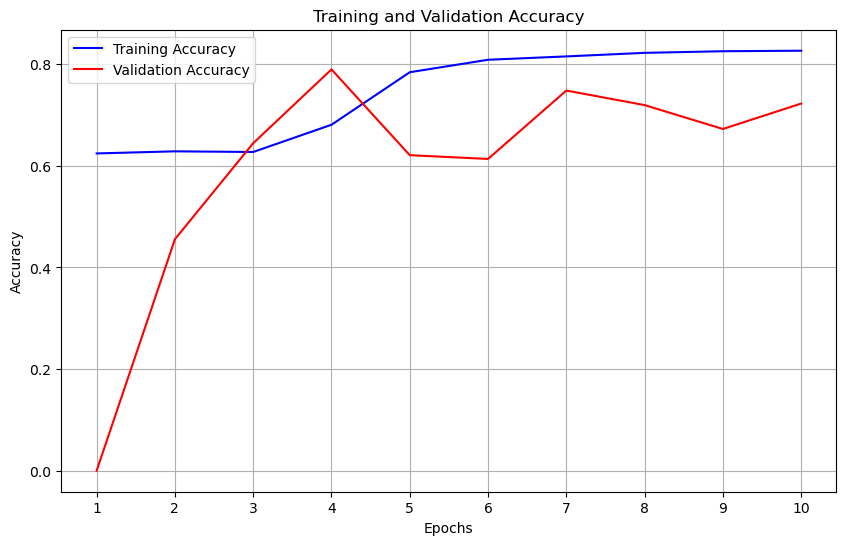

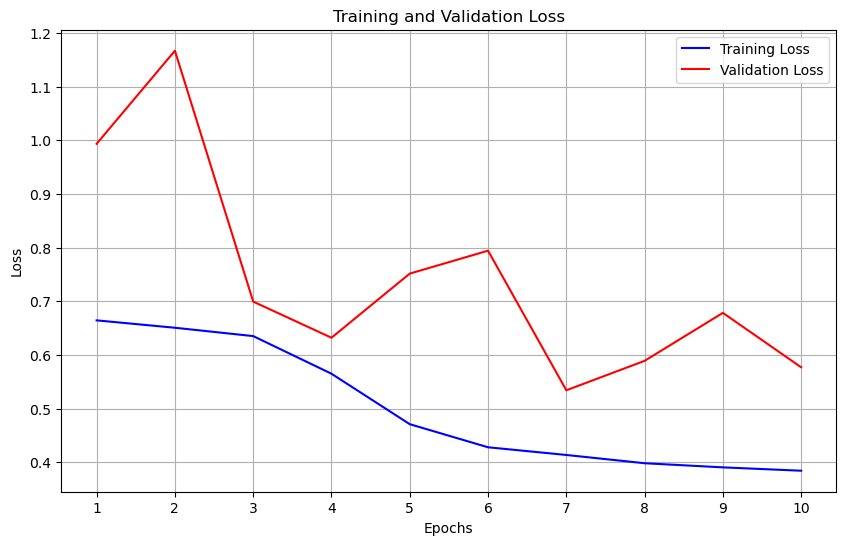

In [23]:
plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.6136 - loss: 0.6715 - val_accuracy: 0.0000e+00 - val_loss: 0.9910 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6211 - loss: 0.6583 - val_accuracy: 0.0432 - val_loss: 0.9168 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.6220 - loss: 0.6642 - val_accuracy: 0.0026 - val_loss: 0.9896 - learning_rate: 0.0030
Epoch 4/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6342 - loss: 0.6499
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.6344 - loss: 0.6497 - val_accuracy: 0.1862 - val_loss: 0.9583 - learning_rate: 0.0030
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.6958 - loss: 0.5765 - val_accuracy: 0.8380 - val_loss: 0.4070 - learning_rate: 0.0015
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8019 - loss: 0.4413 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 64)             │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,861 (679.15 KB)

 Trainable params: 57,953 (226.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 115,908 (452.77 KB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
Model Accuracy: 0.78596
Confusion Matrix:
 [[10583  1917]
 [ 3434  9066]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80     12500
           1       0.83      0.73      0.77     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



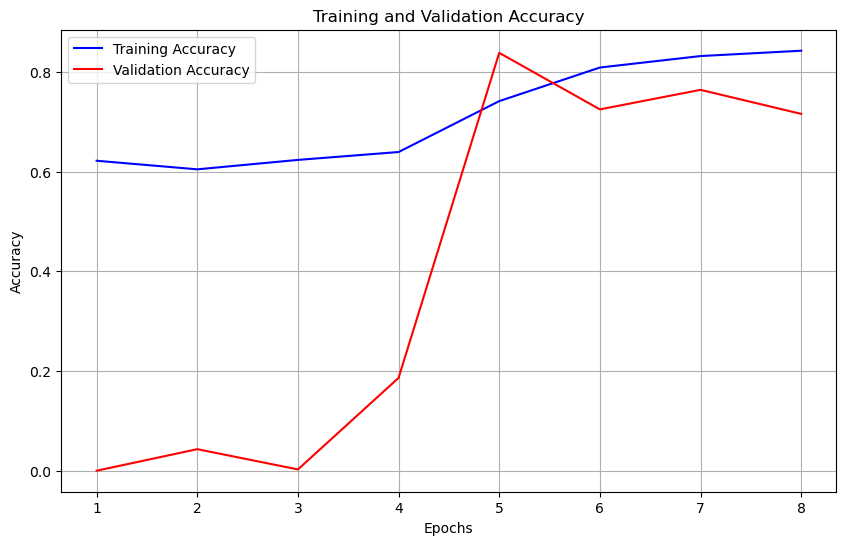

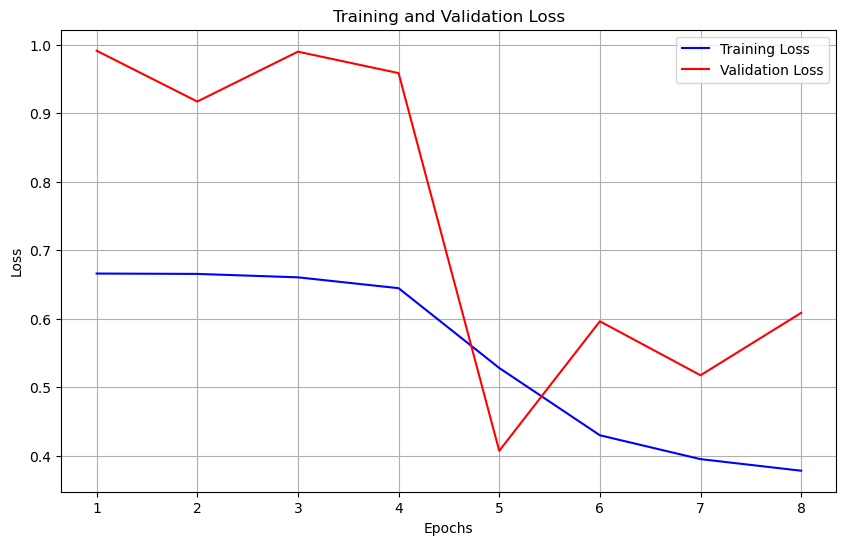

In [24]:
num_words = 750  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.6197 - loss: 0.6687 - val_accuracy: 0.0000e+00 - val_loss: 0.9901 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.6247 - loss: 0.6523 - val_accuracy: 0.4496 - val_loss: 0.7612 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.6802 - loss: 0.5937 - val_accuracy: 0.7986 - val_loss: 0.5199 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.7952 - loss: 0.4562 - val_accuracy: 0.7482 - val_loss: 0.5882 - learning_rate: 0.0030
Epoch 5/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8392 - loss: 0.3812
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.8393 - loss: 0.3808 - val_accuracy: 0.7376 - val_loss: 0.5256 - learning_rate: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.8559 - loss: 0.3484 - val

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 150, 64)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,861 (866.65 KB)

 Trainable params: 73,953 (288.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,908 (577.77 KB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
Model Accuracy: 0.8206
Confusion Matrix:
 [[ 9525  2975]
 [ 1510 10990]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81     12500
           1       0.79      0.88      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



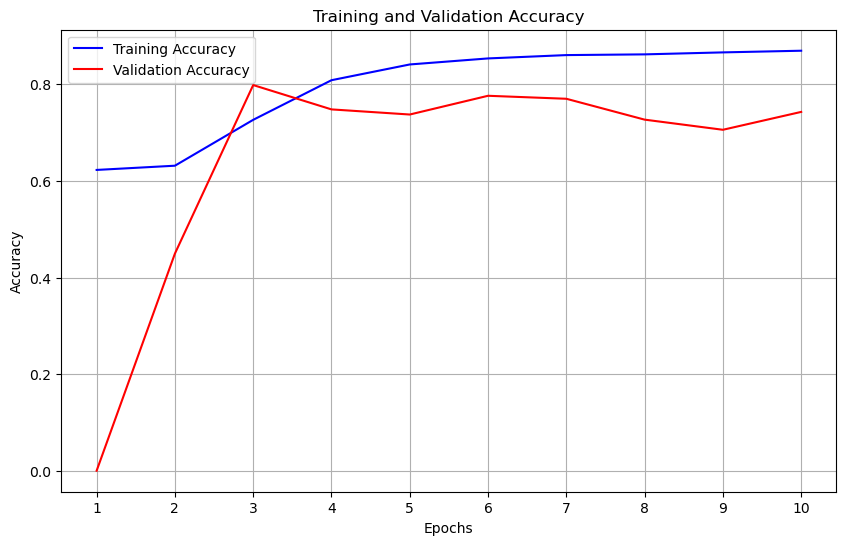

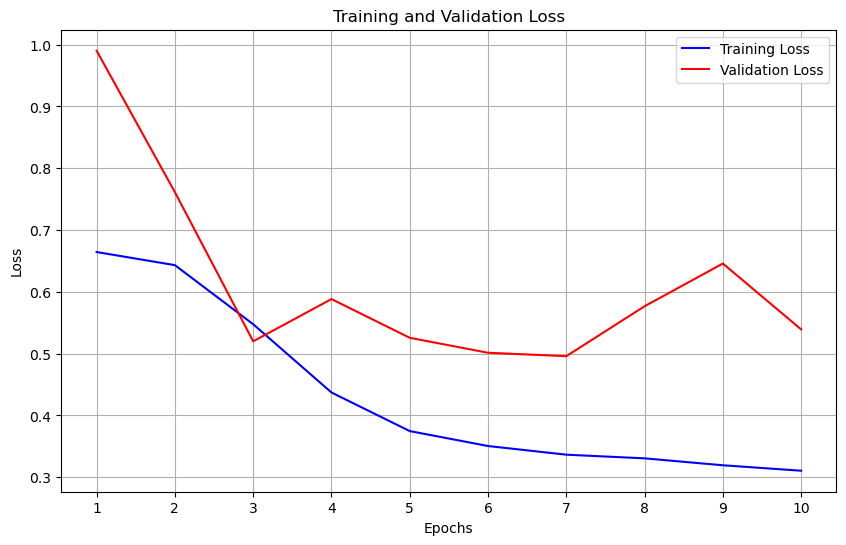

In [25]:
num_words = 1000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.6159 - loss: 0.6692 - val_accuracy: 0.0000e+00 - val_loss: 1.0016 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - accuracy: 0.6249 - loss: 0.6480 - val_accuracy: 0.1560 - val_loss: 1.1760 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6730 - loss: 0.5803
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step - accuracy: 0.6735 - loss: 0.5798 - val_accuracy: 0.4834 - val_loss: 1.1303 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step - accuracy: 0.8128 - loss: 0.4310 - val_accuracy: 0.7456 - val_loss: 0.5973 - learning_rate: 0.0015
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - accuracy: 0.8647 - loss: 0.3294 - val_accuracy: 0.7168 - val_loss: 0.6702 - learning_rate: 0.0015
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 442ms/step - accuracy: 0.8855 - loss: 0.2933 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 150, 128)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,078,085 (4.11 MB)

 Trainable params: 359,361 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 718,724 (2.74 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step
Model Accuracy: 0.83316
Confusion Matrix:
 [[10146  2354]
 [ 1817 10683]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83     12500
           1       0.82      0.85      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



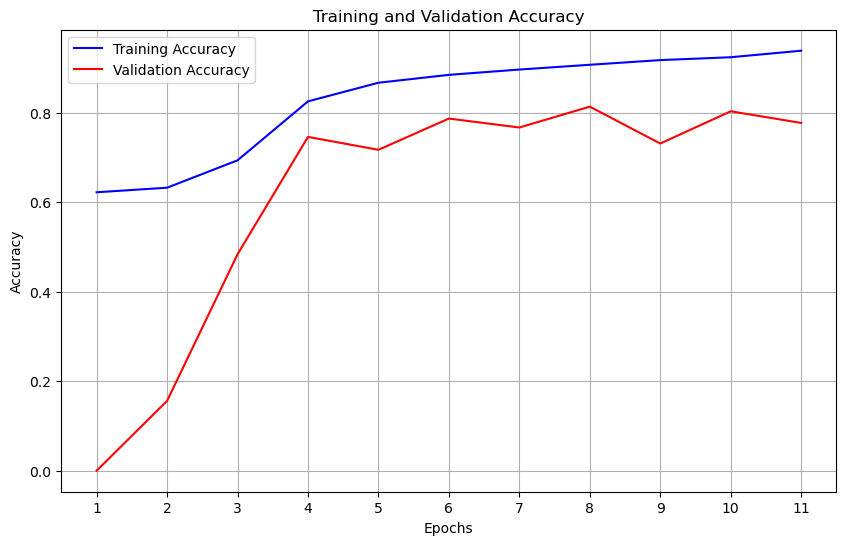

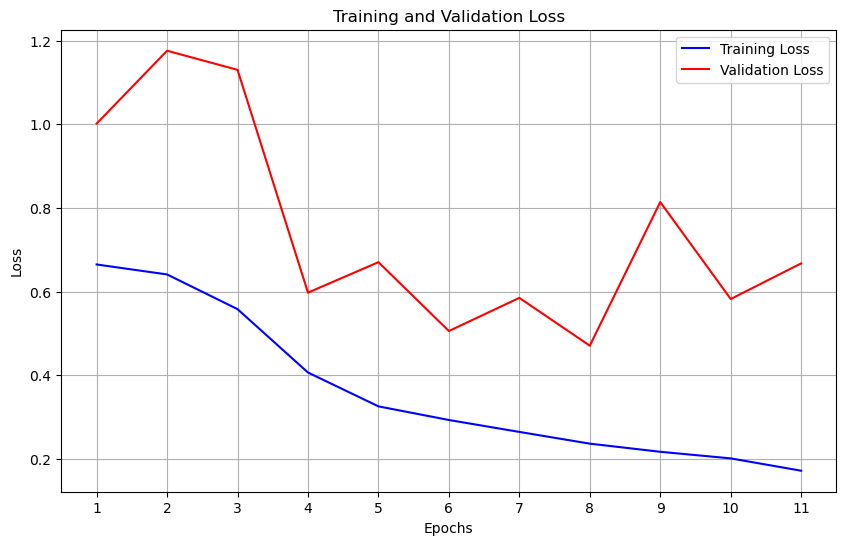

In [26]:
num_words = 2500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - accuracy: 0.6022 - loss: 0.6712 - val_accuracy: 0.0000e+00 - val_loss: 0.9391 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 420ms/step - accuracy: 0.6310 - loss: 0.6472 - val_accuracy: 0.0010 - val_loss: 0.9162 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - accuracy: 0.6443 - loss: 0.6261 - val_accuracy: 0.6862 - val_loss: 0.7542 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - accuracy: 0.8166 - loss: 0.4344 - val_accuracy: 0.7992 - val_loss: 0.4658 - learning_rate: 0.0030
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 433ms/step - accuracy: 0.8917 - loss: 0.2852 - val_accuracy: 0.6906 - val_loss: 0.7624 - learning_rate: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - accuracy: 0.9270 - loss: 0.2060 - val_accuracy: 0.8392 - val_loss: 0.3936 - learning_rate: 0.0030
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - accuracy: 0.9434 - loss: 0.1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 150, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,038,085 (7.77 MB)

 Trainable params: 679,361 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,358,724 (5.18 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step
Model Accuracy: 0.83372
Confusion Matrix:
 [[10521  1979]
 [ 2178 10322]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



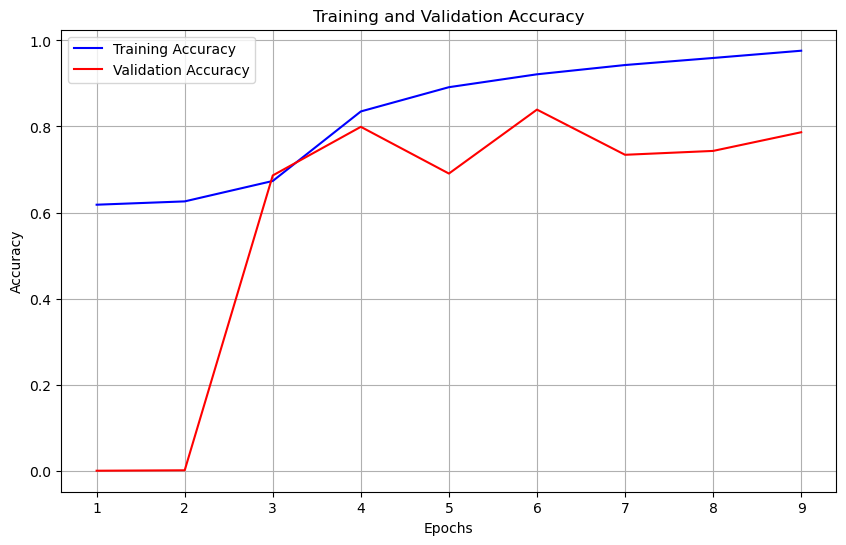

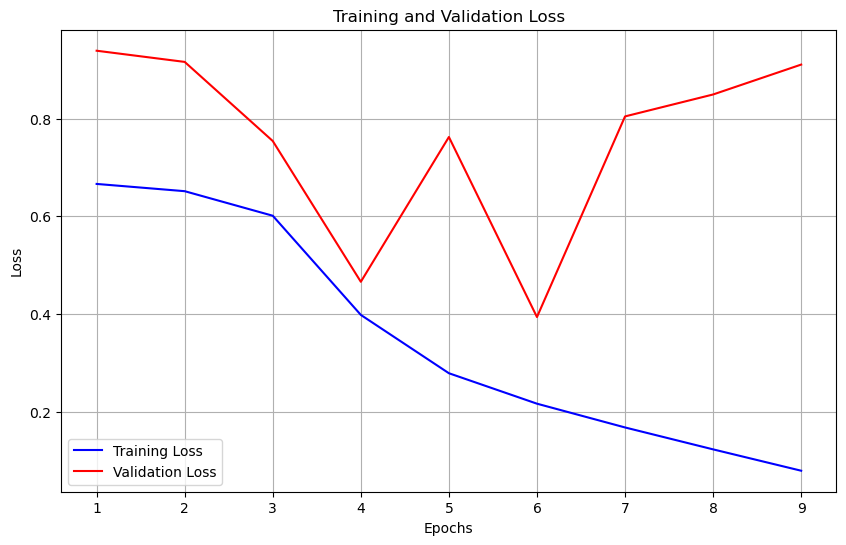

In [27]:
num_words = 5000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.6179 - loss: 0.6699 - val_accuracy: 0.0000e+00 - val_loss: 0.9435 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 423ms/step - accuracy: 0.6266 - loss: 0.6461 - val_accuracy: 0.0640 - val_loss: 1.0358 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.6995 - loss: 0.5660 - val_accuracy: 0.6966 - val_loss: 0.7249 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 462ms/step - accuracy: 0.8467 - loss: 0.3732 - val_accuracy: 0.8286 - val_loss: 0.3987 - learning_rate: 0.0030
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 0.9050 - loss: 0.2491 - val_accuracy: 0.7878 - val_loss: 0.5647 - learning_rate: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9381 - loss: 0.1728
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - accuracy: 0.9381 - loss: 0.1730 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 150, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,038,085 (7.77 MB)

 Trainable params: 679,361 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,358,724 (5.18 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step
Model Accuracy: 0.8358
Confusion Matrix:
 [[10501  1999]
 [ 2106 10394]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



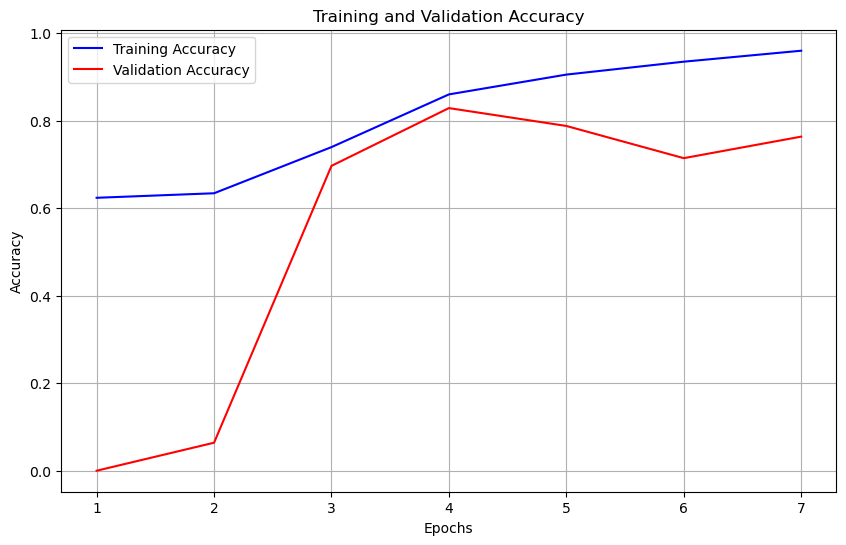

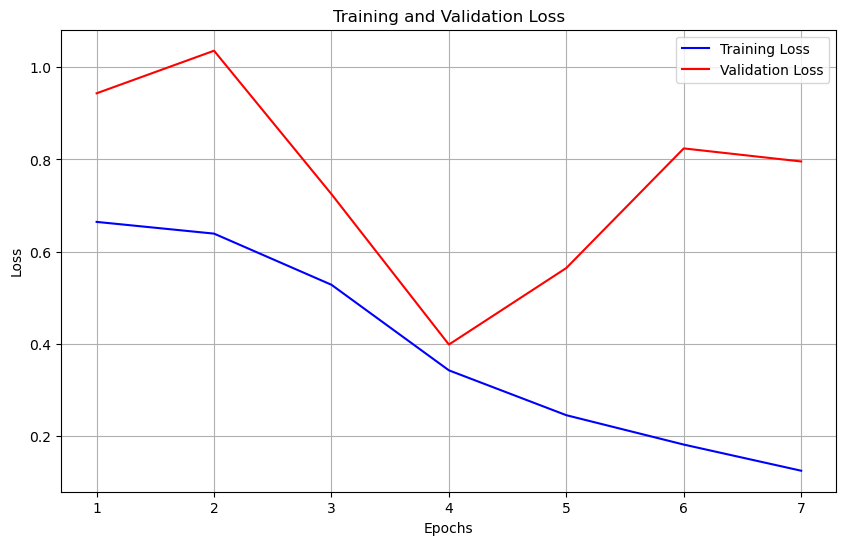

In [28]:
num_words = 5000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('s', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.6079 - loss: 0.6713 - val_accuracy: 0.0698 - val_loss: 1.0024 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.7121 - loss: 0.5601 - val_accuracy: 0.5360 - val_loss: 0.9939 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.8473 - loss: 0.3793 - val_accuracy: 0.7146 - val_loss: 0.6394 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.8977 - loss: 0.2763 - val_accuracy: 0.6974 - val_loss: 0.7185 - learning_rate: 0.0030
Epoch 5/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9272 - loss: 0.2064
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.9270 - loss: 0.2066 - val_accuracy: 0.5882 - val_loss: 1.1342 - learning_rate: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.9299 - loss: 0.1846 - va

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 128)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,998,085 (11.44 MB)

 Trainable params: 999,361 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,998,724 (7.62 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step
Model Accuracy: 0.79444
Confusion Matrix:
 [[ 8889  3611]
 [ 1528 10972]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.78     12500
           1       0.75      0.88      0.81     12500

    accuracy                           0.79     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.79      0.79     25000



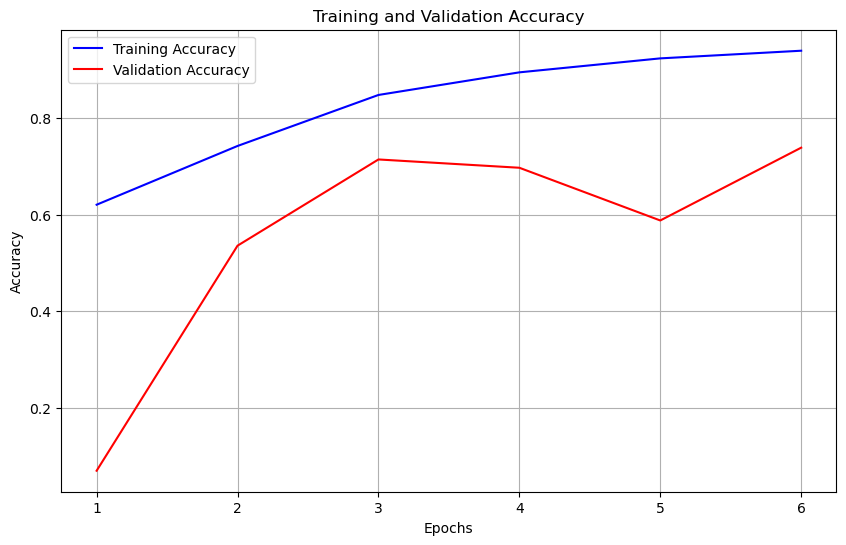

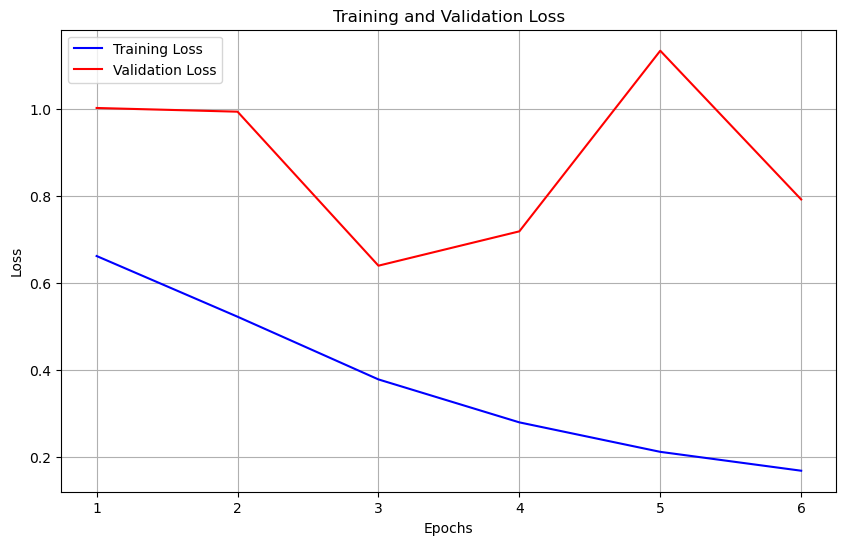

In [29]:
num_words = 7500  # Maximum vocabulary size
max_len = 100  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/10


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.6164 - loss: 0.6697 - val_accuracy: 0.0096 - val_loss: 1.0887 - learning_rate: 0.0030
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - accuracy: 0.6926 - loss: 0.5822 - val_accuracy: 0.6794 - val_loss: 0.7108 - learning_rate: 0.0030
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.8533 - loss: 0.3609 - val_accuracy: 0.6870 - val_loss: 0.7179 - learning_rate: 0.0030
Epoch 4/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8930 - loss: 0.2812
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.8931 - loss: 0.2808 - val_accuracy: 0.6954 - val_loss: 0.8196 - learning_rate: 0.0030
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.9385 - loss: 0.1763 - val_accuracy: 0.7056 - val_loss: 0.8593 - learning_rate: 0.0015
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 100, 128)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,998,085 (11.44 MB)

 Trainable params: 999,361 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,998,724 (7.62 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step
Model Accuracy: 0.78268
Confusion Matrix:
 [[ 8455  4045]
 [ 1388 11112]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76     12500
           1       0.73      0.89      0.80     12500

    accuracy                           0.78     25000
   macro avg       0.80      0.78      0.78     25000
weighted avg       0.80      0.78      0.78     25000



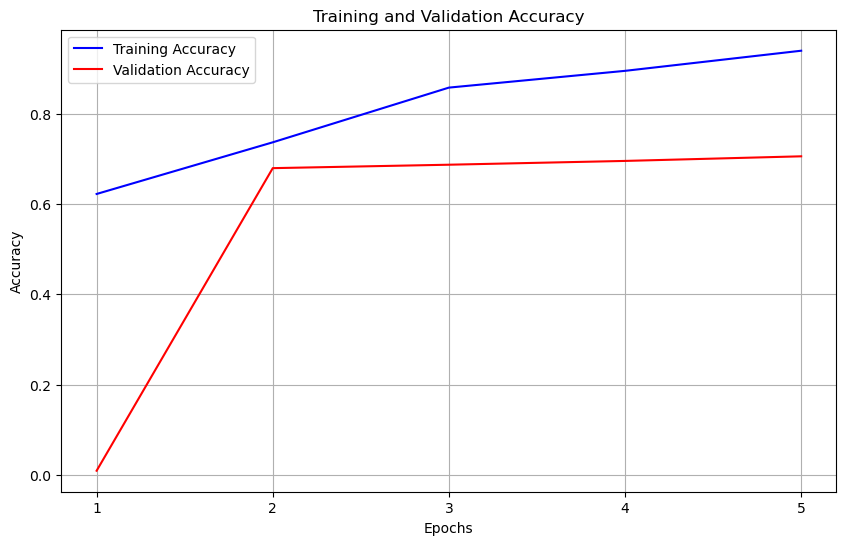

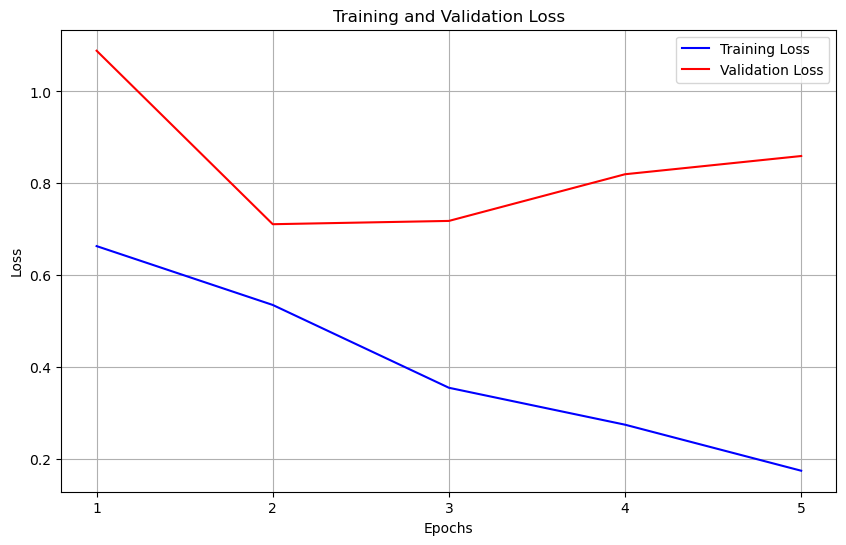

In [30]:
num_words = 7500  # Maximum vocabulary size
max_len = 100  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('s', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/10


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6053 - loss: 0.6716 - val_accuracy: 0.0000e+00 - val_loss: 0.9655 - learning_rate: 0.0030
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 997ms/step - accuracy: 0.6301 - loss: 0.6551 - val_accuracy: 2.0000e-04 - val_loss: 0.9926 - learning_rate: 0.0030
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 959ms/step - accuracy: 0.6586 - loss: 0.6181 - val_accuracy: 0.5152 - val_loss: 0.9022 - learning_rate: 0.0030
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8528 - loss: 0.3611 - val_accuracy: 0.8286 - val_loss: 0.3982 - learning_rate: 0.0030
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9291 - loss: 0.2034 - val_accuracy: 0.7560 - val_loss: 0.6979 - learning_rate: 0.0030
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.9635 - loss: 0.1106
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 990ms/step - accuracy: 0.9635 - loss: 0.1107 - val_accu

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 150, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,149,637 (31.09 MB)

 Trainable params: 2,716,545 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,433,092 (20.73 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step
Model Accuracy: 0.8146
Confusion Matrix:
 [[10446  2054]
 [ 2581  9919]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82     12500
           1       0.83      0.79      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000



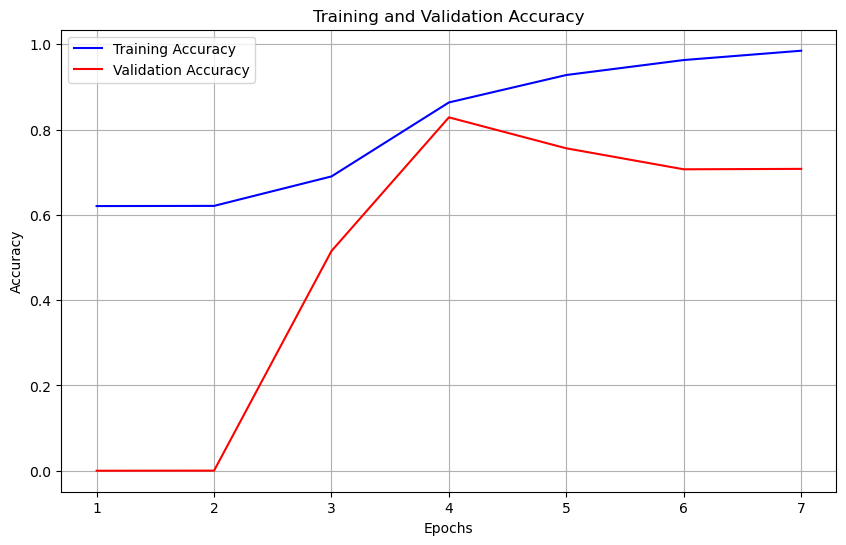

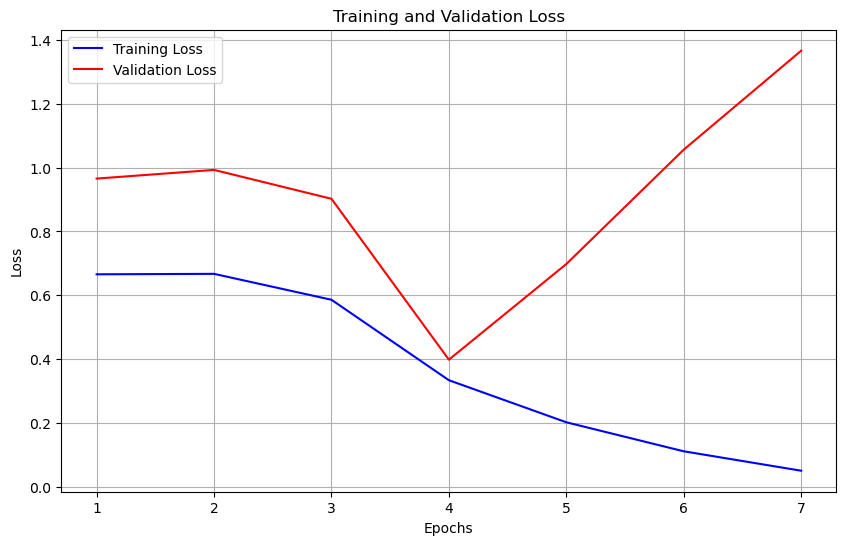

In [31]:
num_words = 10000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'l'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/100


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 990ms/step - accuracy: 0.6205 - loss: 0.6665 - val_accuracy: 0.0000e+00 - val_loss: 0.8667 - learning_rate: 0.0030
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6152 - loss: 0.6692 - val_accuracy: 0.0000e+00 - val_loss: 1.0058 - learning_rate: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6487 - loss: 0.6003 - val_accuracy: 0.6692 - val_loss: 0.6938 - learning_rate: 0.0030
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8733 - loss: 0.3177 - val_accuracy: 0.6548 - val_loss: 0.8661 - learning_rate: 0.0030
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9284 - loss: 0.1922
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9283 - loss: 0.1922 - val_accuracy: 0.7104 - val_loss: 0.8178 - learning_rate: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9685 - loss: 0.1037 - val_accuracy

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 150, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,149,637 (31.09 MB)

 Trainable params: 2,716,545 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,433,092 (20.73 MB)

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step
Model Accuracy: 0.77648
Confusion Matrix:
 [[ 8433  4067]
 [ 1521 10979]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.67      0.75     12500
           1       0.73      0.88      0.80     12500

    accuracy                           0.78     25000
   macro avg       0.79      0.78      0.77     25000
weighted avg       0.79      0.78      0.77     25000



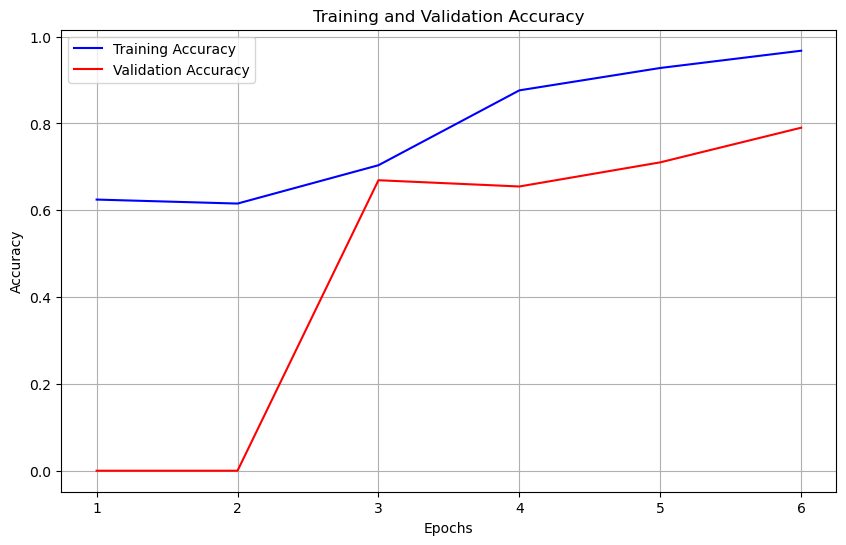

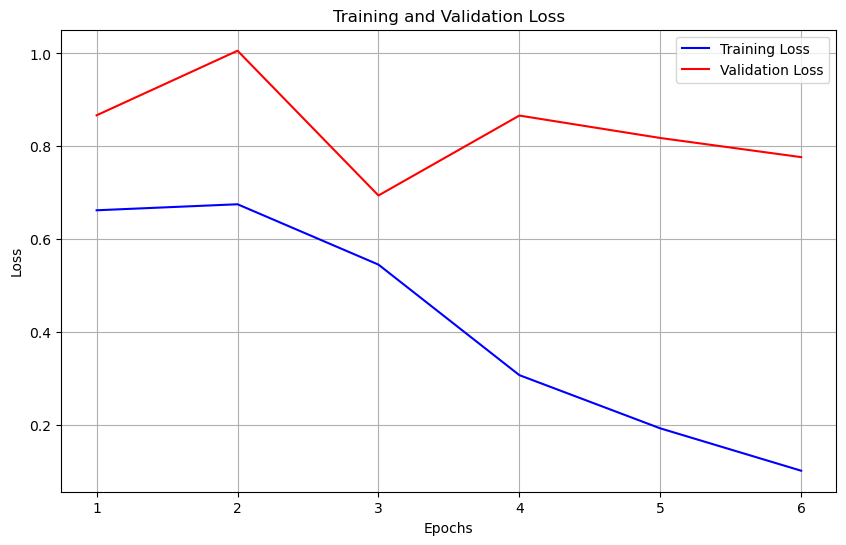

In [32]:
num_words = 10000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'l'  # Model size ('s', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/10


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 744ms/step - accuracy: 0.6122 - loss: 0.6716 - val_accuracy: 0.0000e+00 - val_loss: 1.0091 - learning_rate: 0.0030
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 714ms/step - accuracy: 0.6430 - loss: 0.6316 - val_accuracy: 0.4986 - val_loss: 0.9658 - learning_rate: 0.0030
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 76s 637ms/step - accuracy: 0.8702 - loss: 0.3344 - val_accuracy: 0.6948 - val_loss: 0.6518 - learning_rate: 0.0030
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 695ms/step - accuracy: 0.9582 - loss: 0.1293 - val_accuracy: 0.6466 - val_loss: 1.2090 - learning_rate: 0.0030
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9796 - loss: 0.0614
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 754ms/step - accuracy: 0.9797 - loss: 0.0613 - val_accuracy: 0.7710 - val_loss: 1.0502 - learning_rate: 0.0030
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 751ms/step - accuracy: 0.9969 - loss: 0.0163 - val

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 150, 256)            │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_10 (GRU)                         │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,829,637 (60.39 MB)

 Trainable params: 5,276,545 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,553,092 (40.26 MB)

98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 237ms/step
Model Accuracy: 0.79776
Confusion Matrix:
 [[ 8830  3670]
 [ 1386 11114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78     12500
           1       0.75      0.89      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



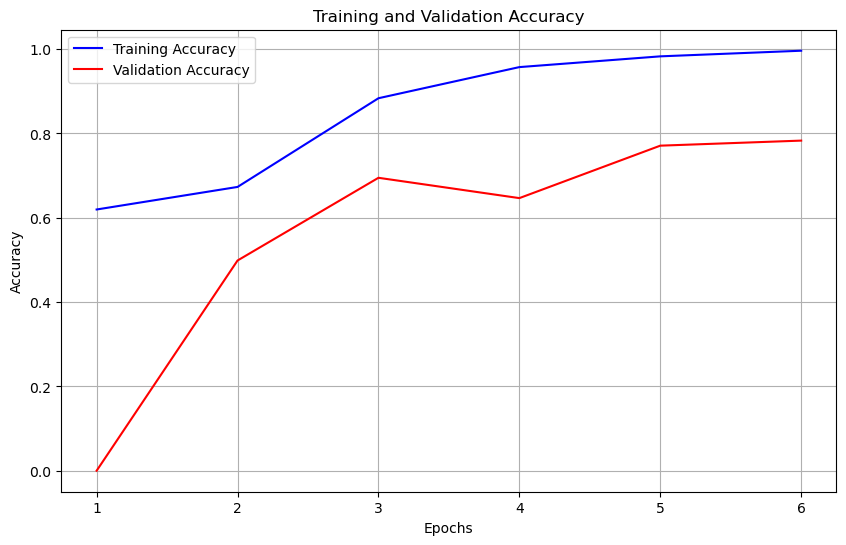

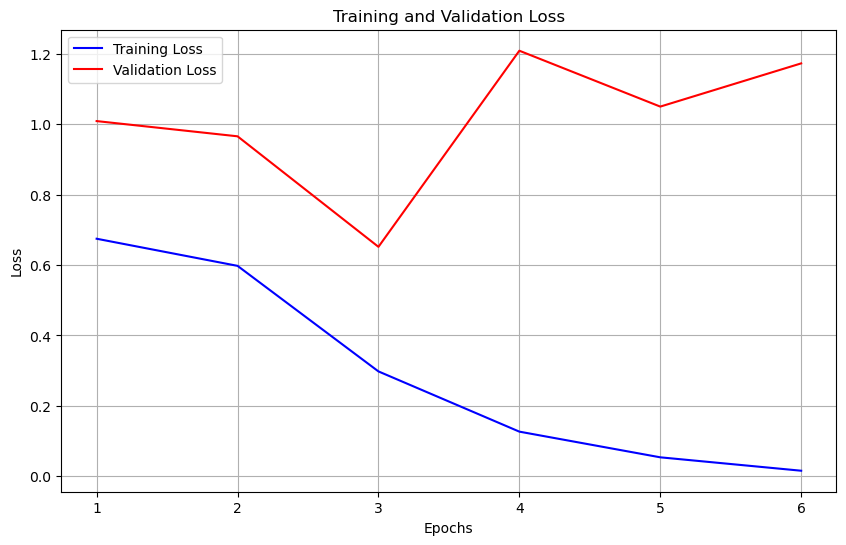

In [33]:
num_words = 20000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 256  # Batch size
model_size = 'l'  # Model size ('s', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)

Epoch 1/10


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 645ms/step - accuracy: 0.6169 - loss: 0.6669 - val_accuracy: 0.2616 - val_loss: 1.1367 - learning_rate: 0.0030
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 546ms/step - accuracy: 0.6941 - loss: 0.5816 - val_accuracy: 0.9302 - val_loss: 0.2234 - learning_rate: 0.0030
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 648ms/step - accuracy: 0.8934 - loss: 0.2651 - val_accuracy: 0.8366 - val_loss: 0.4218 - learning_rate: 0.0030
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9713 - loss: 0.0937
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 600ms/step - accuracy: 0.9713 - loss: 0.0937 - val_accuracy: 0.7912 - val_loss: 0.7643 - learning_rate: 0.0030
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 603ms/step - accuracy: 0.9923 - loss: 0.0288 - val_accuracy: 0.7684 - val_loss: 1.1355 - learning_rate: 0.0015
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 150, 256)            │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,829,637 (60.39 MB)

 Trainable params: 5,276,545 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,553,092 (40.26 MB)

98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step
Model Accuracy: 0.77636
Confusion Matrix:
 [[11697   803]
 [ 4788  7712]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81     12500
           1       0.91      0.62      0.73     12500

    accuracy                           0.78     25000
   macro avg       0.81      0.78      0.77     25000
weighted avg       0.81      0.78      0.77     25000



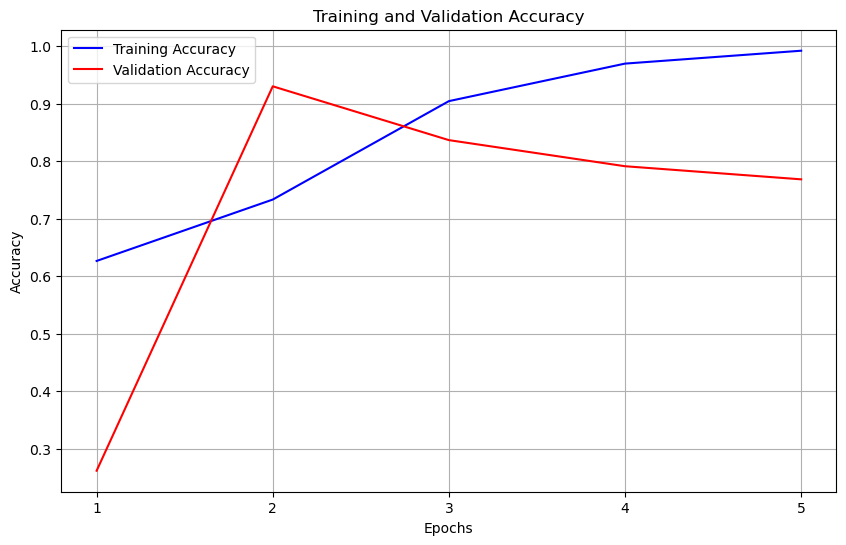

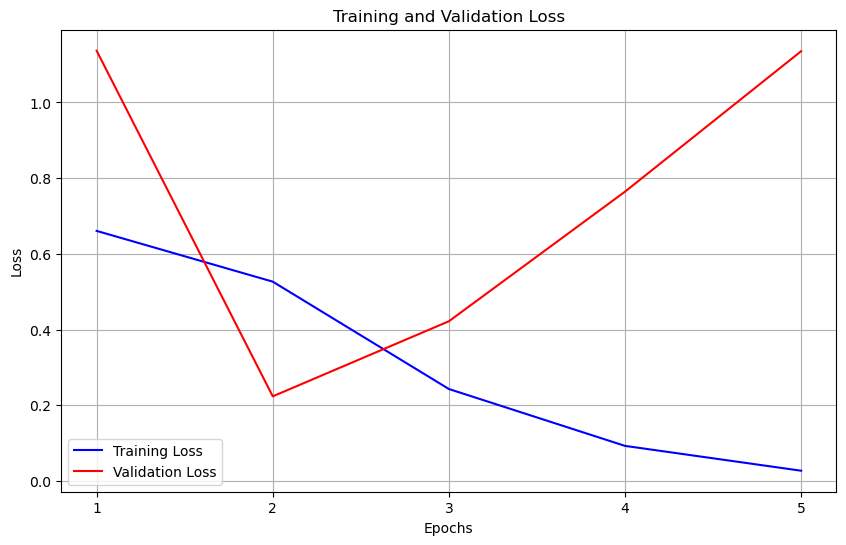

In [34]:
num_words = 20000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 256  # Batch size
model_size = 'l'  # Model size ('s', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_RNN(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_accuracy(trained_model)
plot_loss(trained_model)